In [49]:
import getpass
user_id = getpass.getuser()

import sys
sys.path.append(f"/home/{user_id}/OTTEHR/")

import matplotlib.pyplot as plt
from mimic_common import *
import os
import pandas as pd
from statistics import median, stdev
import seaborn as sns

In [50]:

def ratios_for_metrics(group_name, group_2, group_1, eval_metric, trans_metrics):
    """ 
    Compute ratios for the evaluation metrics (eval_metric)

    :param str eval_metric: evaluation metric, mae or rmse
    :param str trans_metric: transporting metric, OT, TCA or MMD
    """

    metric_improve_ratios = []
    score_dir = mimic_output_dir
    for trans_metric in trans_metrics:
        score_path = os.path.join(score_dir, f"exp4_{group_name}_{group_2}2{group_1}_{trans_metric}.csv")
        score_df = pd.read_csv(score_path, header=0, index_col=0)

        # compute improvements in terms of ratio
        metric_improve_ratios.append(compute_metric_ratio(score_df, eval_metric))

    return metric_improve_ratios


In [51]:

def stats_for_metrics(group_name, group_2, group_1, eval_metric, trans_metrics, filter_na = True):
    """ 
    Compute ratios for the evaluation metrics (eval_metric)

    :param str eval_metric: evaluation metric, mae or rmse
    :param str trans_metric: transporting metric, OT or DeepJDOT
    """
    metric_stats = []
    score_dir = mimic_output_dir
    for trans_metric in trans_metrics:
        score_path = os.path.join(score_dir, f"exp4_{group_name}_{group_2}2{group_1}_{trans_metric}.csv")

        score_df = pd.read_csv(score_path, header=0, index_col=None)

        # get target metric
        metric_stats.append(get_target_stats(score_df, eval_metric, trans_metric, filter_na))

    return metric_stats

In [52]:
def print_median_std(ratios, trans_metrics, eval_metric):
    """ 
    Get median and standard deviation for the ratios of trans_metrics ('OT', 'TCA', 'MMD')
    """
    for i, trans_metric in enumerate(trans_metrics):
        print(f'{eval_metric} for {trans_metric}, Median: {median(ratios[i]):.1%}, Stdev: {stdev(ratios[i]):.1%}')

In [53]:
score_dir = f"/home/{user_id}/OTTEHR/outputs/mimic/"

# eval_metric = 'MAE'
eval_metric = 'RMSE'

# group_name = 'insurance'
# groups = ['Self_Pay', 'Private', 'Government', 'Medicare', 'Medicaid']

group_name = 'marital_status'
groups = ['SEPARATED', 'DIVORCED', 'MARRIED','WIDOWED', 'SINGLE']

# trans_metrics = ['OT', 'TCA', 'CA', 'GFK']
trans_metrics = ['GWOT', 'OT']




medians for each method is: [0.18356764 0.09120285]
        GWOT        OT
0   0.366673  0.097168
1   0.250704  0.110142
2   0.186052  0.080198
3   0.143289  0.115859
4   0.297825  0.207281
..       ...       ...
95  0.123392  0.016125
96  0.354078  0.170335
97  0.063869  0.001876
98  0.212379  0.087554
99  0.127800  0.028827

[100 rows x 2 columns]


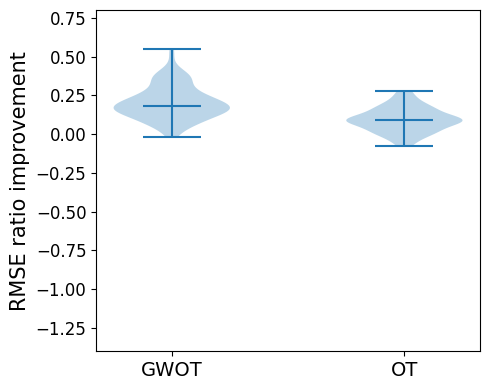

In [54]:
# Overall, for all groups
improve_ratio_combined = []

for group_1 in groups:
    for group_2 in groups:
        if group_1 == group_2:
            continue        
        improve_ratios = ratios_for_metrics(group_name, group_1, group_2, eval_metric, trans_metrics)
        improve_ratio_combined.extend(improve_ratios)

trans_metric_dict = {}
for i in range(len(trans_metrics)):
    trans_metric_dict[trans_metrics[i]] = improve_ratio_combined[i]
# print(np.median(trans_metric_dict['GWOT']))
data = pd.DataFrame(trans_metric_dict)
print("medians for each method is:", np.median(data, axis=0))
print(data)


# Plot the dataframe
plt.figure(figsize=[5, 4])
plt.violinplot(data, showmedians=True)
plt.xticks(range(1, len(trans_metrics)+1), labels=trans_metrics)
plt.ylabel(f"{eval_metric} ratio improvement", fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax = plt.gca()
ax.set_xticklabels( labels=trans_metrics, fontsize=14)
plt.ylim(-1.4, 0.8)
fig_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{eval_metric}_ratio.pdf")
plt.tight_layout()
plt.savefig(fig_path, bbox_inches='tight')
plt.show()

In [55]:
def print_latex(source, target, ratios, percent):
    """ 
    Print latex for ratios
    """

    print_str = f"{source.title()} & {target.title()}"
    for ratio in ratios:
        if percent:
            print_str += f' & {median(ratio)*100:.1f}({stdev(ratio)*100:.1f})'
        else: 
            base = 10**5
            print_str += f' & {median(ratio)/base:.1f}({stdev(ratio)/base:.1f})'
    print_str += ' \\\ \hline'
    print(print_str)
    

In [56]:
for i, group_1 in enumerate(groups):
    for j, group_2 in enumerate(groups):
        if i <= j:
            continue
        # print(f"group 1: {group_1}, group_2: {group_2}")
        # mae_improve_ratios = ratios_for_metrics(group_name, group_1, group_2, 'mae', trans_metrics)
        # print_median_std(mae_improve_ratios, trans_metrics, 'MAE')
        improve_ratios = ratios_for_metrics(group_name, group_1, group_2, eval_metric, trans_metrics)
        # print(rmse_improve_ratios)
        # print_median_std(rmse_improve_ratios, trans_metrics, eval_metric)
        print_latex(group_1, group_2, improve_ratios, percent=True)

Divorced & Separated & 32.1(12.8) & 15.7(11.7) \\ \hline
Married & Separated & 30.8(13.2) & 13.0(12.2) \\ \hline
Married & Divorced & 23.1(13.8) & 9.5(11.7) \\ \hline
Widowed & Separated & 39.3(13.6) & 19.1(12.7) \\ \hline
Widowed & Divorced & 32.3(12.9) & 16.7(12.1) \\ \hline
Widowed & Married & 31.8(9.3) & 15.6(9.0) \\ \hline
Single & Separated & 26.9(12.0) & 13.6(10.9) \\ \hline
Single & Divorced & 21.6(12.3) & 9.0(11.5) \\ \hline
Single & Married & 21.8(11.2) & 11.1(10.1) \\ \hline
Single & Widowed & 18.7(11.3) & 8.1(10.1) \\ \hline


median is: 10.309527937318926, 11.003235


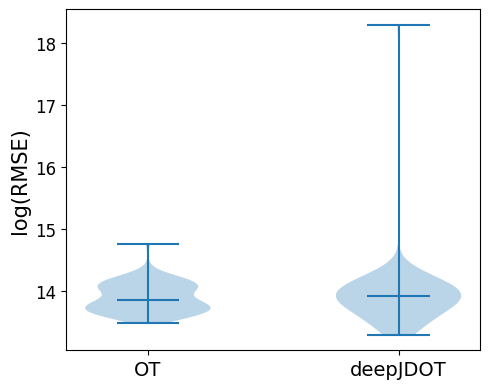

In [57]:
# Present the overall performance for deepJDOT and OTTEHR
trans_metrics = ['OT', 'deepJDOT']
stats_combined = []

for group_1 in groups:
    for group_2 in groups:
        if group_1 == group_2:
            continue        
        stats = stats_for_metrics(group_name, group_1, group_2, eval_metric, trans_metrics, filter_na=True)
        stats_combined.extend(stats)

# fig_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_deepJDOT.pdf")

# plt.tight_layout()
# plt.savefig(fig_path, bbox_inches='tight')
# plt.show()

base = 10**5
print(f"median is: {median(stats_combined[0])/base}, {median(stats_combined[1])/base}")

# Apply log to stats_combined
for i in range(len(stats_combined)):
    stats_combined[i] = [np.log(x) for x in stats_combined[i]]


# Plot the dataframe
plt.figure(figsize=[5, 4])
plt.violinplot([stats_combined[0], stats_combined[1]], showmedians=True)
# plt.violinplot([stats_combined[0], stats_combined[1], stats_combined[2], stats_combined[3], stats_combined[4]], showmedians=True)
plt.xticks(range(1, len(trans_metrics)+1), labels=trans_metrics)
plt.ylabel(f"log({eval_metric})", fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
ax = plt.gca()
ax.set_xticklabels(labels=trans_metrics, fontsize=14)
# plt.ylim(12, 22)
fig_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{eval_metric}_deepJDOT.pdf")
plt.tight_layout()
plt.savefig(fig_path, bbox_inches='tight')
plt.show()

In [58]:
# Calculate the pairwise performance for deepJDOT and OTTEHR


for i, group_1 in enumerate(groups):
    for j, group_2 in enumerate(groups):
        if i <= j:
            continue
        stats = stats_for_metrics(group_name, group_1, group_2, eval_metric, trans_metrics, filter_na=True)

        print_latex(group_1, group_2, stats, percent=False)

Divorced & Separated & 9.9(3.6) & 8.4(3.0) \\ \hline
Married & Separated & 10.1(2.7) & 8.3(14.1) \\ \hline
Married & Divorced & 9.4(2.2) & 8.4(6.5) \\ \hline
Widowed & Separated & 9.5(2.7) & 7.4(1.7) \\ \hline
Widowed & Divorced & 8.6(3.3) & 7.1(4718.1) \\ \hline
Widowed & Married & 8.6(1.7) & 6.9(4431.5) \\ \hline
Single & Separated & 10.6(2.4) & 9.7(2.4) \\ \hline
Single & Divorced & 10.1(2.6) & 8.9(4183.2) \\ \hline
Single & Married & 10.4(2.9) & 9.8(2025.3) \\ \hline
Single & Widowed & 9.7(2.1) & 9.3(2887.8) \\ \hline


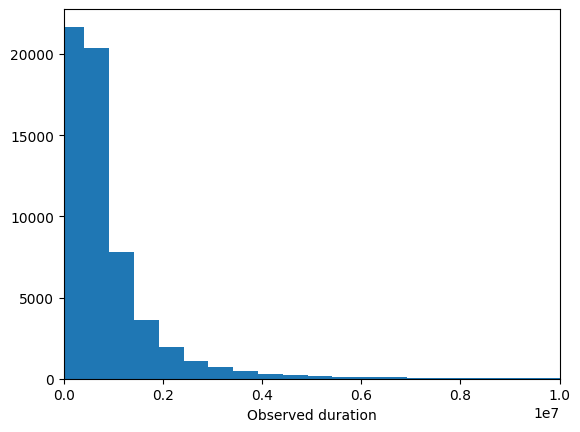

In [59]:
# Plot the distribution of the observed duration in hospital
admid_diagnosis_df = pd.read_csv(os.path.join(mimic_output_dir, "ADMID_DIAGNOSIS.csv"), index_col=0, header=0, converters={'ICD codes': literal_eval})
admid_diagnosis_df['duration']
durations = list(admid_diagnosis_df['duration'])
binwidth = 0.05*10**7
plt.hist(durations, bins=np.arange(min(durations), max(durations) + binwidth, binwidth))
plt.xlim(0, 10**7)
plt.xlabel('Observed duration')
plt.savefig(os.path.join(mimic_output_dir, "observed_duration_distn.pdf"))


In [60]:
# Analyze the precision and recall of the task 
# From the previous plot, we use 1e6 as the threshold 